## 1. Import the data


In [15]:
import requests
import zipfile
import os

# URL of the file to download
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"

# Local filename
filename = "10_food_classes_all_data.zip"

# Download the file
response = requests.get(url)
with open(filename, 'wb') as file:
    file.write(response.content)

# Unzip the file
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall()
zip_ref.close()

# Remove the zip file
os.remove(filename)

In [16]:
# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [18]:
# Get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [19]:
# Same function as binary classification

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img

Image shape: (511, 512, 3)


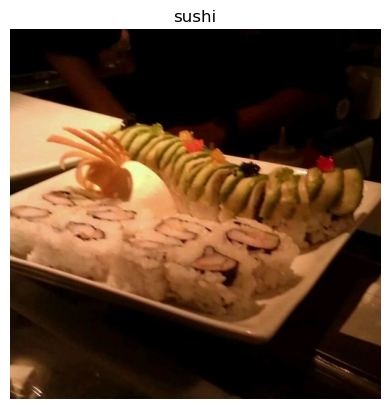

In [34]:
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## 2. Preprocess the data

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Get all pixel values between 0 & 1
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32, 
                                               target_size=(224,224), 
                                               class_mode="categorical") # defaul
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## 3. Create a CNN model

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

# Create the model (will be the baseline)
model = Sequential([
    Conv2D(filters=10,
          kernel_size=3,
          activation="relu",
          input_shape=(224,224,3)),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Conv2D(10,3,activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(units=10, activation="softmax") # Changed to have 10 output neurons and use softmax activation function 
])

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=["accuracy"])

## 4. Fit the model

In [40]:
history = model.fit(train_data, # this is a combination of labels and sample data (parameters "x" & "y")
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 91s 387ms/step - loss: 2.2320 - accuracy: 0.1709 - val_loss: 2.1077 - val_accuracy: 0.2424
Epoch 2/5
235/235 [==============================] - 102s 432ms/step - loss: 1.9211 - accuracy: 0.3337 - val_loss: 2.0369 - val_accuracy: 0.2828
Epoch 3/5
235/235 [==============================] - 108s 459ms/step - loss: 1.2366 - accuracy: 0.5929 - val_loss: 2.3636 - val_accuracy: 0.2524
Epoch 4/5
235/235 [==============================] - 111s 472ms/step - loss: 0.4935 - accuracy: 0.8427 - val_loss: 3.5699 - val_accuracy: 0.2364
Epoch 5/5
235/235 [==============================] - 112s 475ms/step - loss: 0.1592 - accuracy: 0.9556 - val_loss: 4.9632 - val_accuracy: 0.2320


## 5. Evaluate the model

In [41]:
model.evaluate(test_data)

79/79 [==============================] - 8s 98ms/step - loss: 4.9632 - accuracy: 0.2320


[4.963176250457764, 0.23199999332427979]

In [42]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

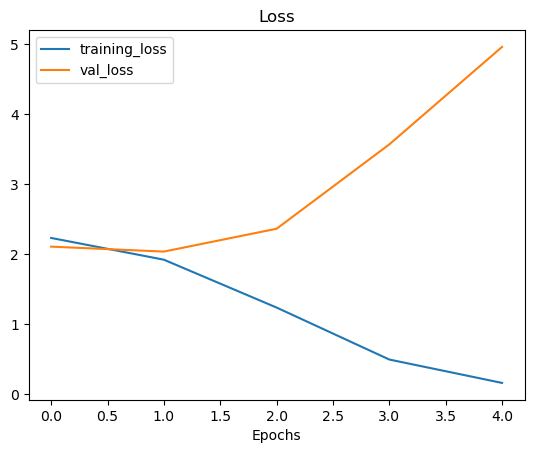

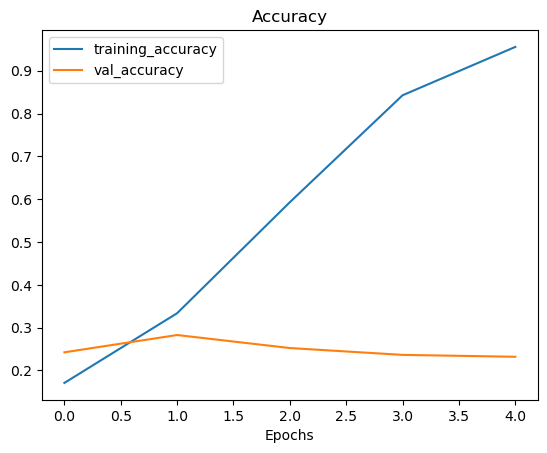

In [43]:
plot_loss_curves(history)

>⚠️ When a model's **validation loss starts to increase**, it's likely that the model is **overfitting** the training dataset.

## 6. Adjust the model parameters
Fitting a machine learning model comes in 3 steps:

0. Create a baseline.
1. Beat the baseline by overfittinga larger model.
2. Reduce overfitting.

Ways to induce overfitting:
* Increase the number of conv layers.
* Increase the number of conv filters.
* Add another dense layer to the output of our flattened layer.

A couple of ways to prevent overfitting include:

* **Get more data** - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
* **Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
* **Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
* **Use transfer learning** - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.
>🔑 Note: Preventing overfitting is also referred to as regularization.

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                 

In [49]:
# Let's try to remove 2 conv2D layers
model_2 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax")
])

model_2.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

In [52]:
# Fit the model with half convolutional layers
history_2 = model_2.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 44s 186ms/step - loss: 0.4281 - accuracy: 0.8879 - val_loss: 2.9615 - val_accuracy: 0.2804
Epoch 2/5
235/235 [==============================] - 46s 195ms/step - loss: 0.2110 - accuracy: 0.9533 - val_loss: 3.4606 - val_accuracy: 0.2656
Epoch 3/5
235/235 [==============================] - 45s 193ms/step - loss: 0.1066 - accuracy: 0.9824 - val_loss: 3.9407 - val_accuracy: 0.2664
Epoch 4/5
235/235 [==============================] - 46s 195ms/step - loss: 0.0450 - accuracy: 0.9965 - val_loss: 4.3005 - val_accuracy: 0.2736
Epoch 5/5
235/235 [==============================] - 45s 193ms/step - loss: 0.0231 - accuracy: 0.9976 - val_loss: 4.5572 - val_accuracy: 0.2404


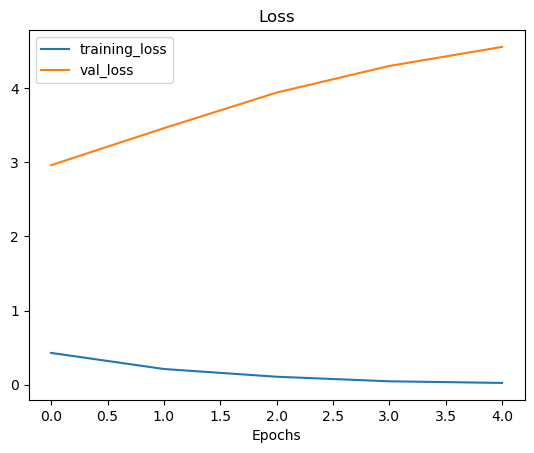

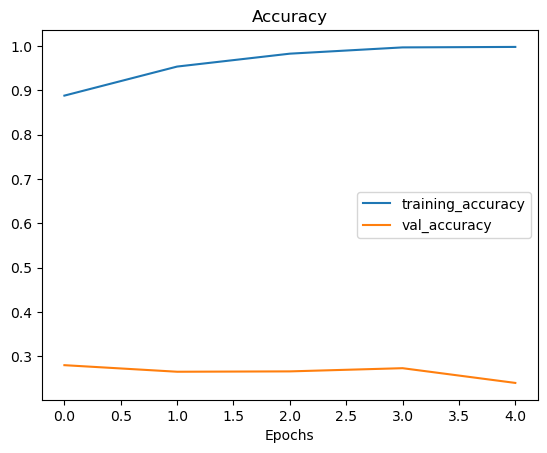

In [53]:
plot_loss_curves(history_2)

In [54]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 29160)             0         
                                                                 
 dense_4 (Dense)             (None, 10)               

The "*Simplifying the model*" experiment dind't work... the accuracy went down and the overfitting continued...
Lets try with **data augmentation**!

### Trying to reduce overfitting with data augmentation

In [55]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.3,
                                             height_shift_range=0.3,
                                             horizontal_flip=True)
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224,224),
                                                                   batch_size=32,
                                                                   class_mode="categorical")

Found 7500 images belonging to 10 classes.


In [63]:
# Clone the model (use the same architecture)
model_3 = tf.keras.models.clone_model(model)

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

In [64]:
# Fit the model
history_3 = model_3.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 96s 406ms/step - loss: 2.2736 - accuracy: 0.1369 - val_loss: 2.2171 - val_accuracy: 0.1796
Epoch 2/5
235/235 [==============================] - 109s 463ms/step - loss: 2.2314 - accuracy: 0.1612 - val_loss: 2.1306 - val_accuracy: 0.2212
Epoch 3/5
235/235 [==============================] - 113s 482ms/step - loss: 2.1805 - accuracy: 0.1983 - val_loss: 2.0654 - val_accuracy: 0.2512
Epoch 4/5
235/235 [==============================] - 112s 475ms/step - loss: 2.1321 - accuracy: 0.2324 - val_loss: 1.9508 - val_accuracy: 0.3132
Epoch 5/5
235/235 [==============================] - 114s 483ms/step - loss: 2.0673 - accuracy: 0.2728 - val_loss: 1.9223 - val_accuracy: 0.3240


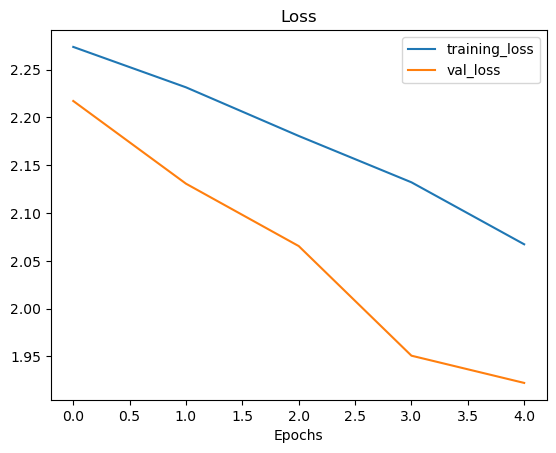

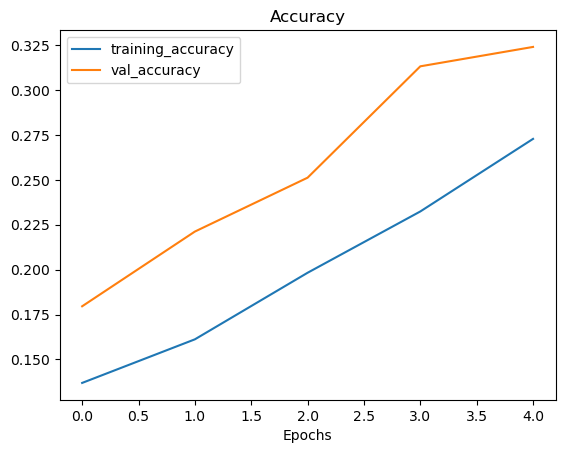

In [65]:
plot_loss_curves(history_3)

## 7. Repeat until satisfied

You can try to approach the loss curves and try to improve the accuracy of validation/test.
How?
- Restructuring the model's architecture (increasing layers/hidden units)
- Adjust the learing rate
- Try different methods of data augmentation
- Training for longer
- Try **transfer learning** 🧐

------
# Making a prediction with our trained model

In [96]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

1/1 [==============================] - 0s 21ms/step


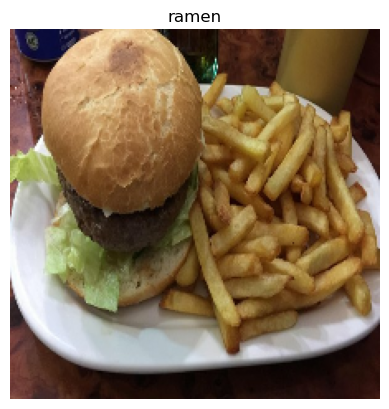

In [97]:
# Load in and preprocess our custom image
img = load_and_prep_image("photo1.jpg")

# Make a prediction
pred = model_3.predict(tf.expand_dims(img, axis=0))

# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False);

In [84]:
# Check the output of the predict function
pred = model_3.predict(tf.expand_dims(img, axis=0))
pred

1/1 [==============================] - 0s 18ms/step


array([[0.06265562, 0.03088326, 0.11200963, 0.09231766, 0.11202779,
        0.09710343, 0.06571969, 0.19911468, 0.09789883, 0.1302695 ]],
      dtype=float32)

In [85]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

### The model didin't perform very well on custom images, but this because it only achieved 32% accuracy on the test data...

------
# Saving and loading the model

In [98]:
# Save the model
model_3.save('saved_model_trained')

INFO:tensorflow:Assets written to: saved_model_trained/assets


INFO:tensorflow:Assets written to: saved_model_trained/assets


In [99]:
# Load in a trained model and evaluate it
loaded_model = tf.keras.models.load_model('saved_model_trained')
loaded_model.evaluate(test_data)

79/79 [==============================] - 8s 105ms/step - loss: 1.9223 - accuracy: 0.3240


[1.9223353862762451, 0.3240000009536743]

In [100]:
# Compare the loaded model with model_3
model_3.evaluate(test_data)

79/79 [==============================] - 8s 103ms/step - loss: 1.9223 - accuracy: 0.3240


[1.9223355054855347, 0.3240000009536743]